In [8]:
#Installing the env

In [1]:
pip install h5py numpy scipy tensorflow matplotlib pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━

In [6]:
import warnings
warnings.filterwarnings("ignore", message="Wswiglal-redir-stdio")
import lal

In [7]:
import lal
lal.swig_redirect_standard_output_error(False)

True

In [18]:
# Import libraries
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, welch
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

In [19]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
# Define preprocessing functions
def normalize(strain):
    """Standardize strain data to zero mean and unit variance."""
    return (strain - np.mean(strain)) / np.std(strain)

def whiten(strain, dt, freq_band=[20, 500]):
    """Whiten strain data using PSD."""
    nperseg = int(fs / 2)  # Reduced for better frequency resolution
    freqs, psd = welch(strain, fs=1/dt, nperseg=nperseg)
    fft_strain = fft(strain)
    freqs_fft = np.fft.fftfreq(len(strain), dt)
    psd_interp = np.interp(np.abs(freqs_fft), freqs, psd)
    white_fft = fft_strain / np.sqrt(psd_interp)
    white_strain = np.real(ifft(white_fft))
    return white_strain, freqs, psd

def bandpass(strain, fs, freq_band=[20, 500]):
    """Apply bandpass filter to strain data."""
    nyquist = fs / 2
    low = freq_band[0] / nyquist
    high = freq_band[1] / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, strain)


In [37]:
# Load the dataset
filename = 'H-H1_LOSC_16_V1-1126259446-32.hdf5'
try:
    with h5py.File(filename, 'r') as f:
        strain = f['strain']['Strain'][:]  # Strain data
        gps_start = f['meta']['GPSstart'][()]  # GPS start time
        duration = f['meta']['Duration'][()]  # Duration (32 seconds)
except FileNotFoundError:
    raise FileNotFoundError(f"File {filename} not found. Download from https://losc.ligo.org/")

In [38]:
# Create time vector
fs = 16384  # Sampling rate (Hz)
dt = 1 / fs
time = np.arange(0, len(strain)) * dt + gps_start

In [39]:
# Preprocessing functions
def whiten(strain, dt, freq_band=[20, 500]):
    nperseg = int(fs)  # Use 1-second segments for PSD estimation
    freqs, psd = welch(strain, fs=1/dt, nperseg=nperseg)
    fft_strain = fft(strain)
    freqs_fft = np.fft.fftfreq(len(strain), dt)
    psd_interp = np.interp(np.abs(freqs_fft), freqs, psd)
    white_fft = fft_strain / np.sqrt(psd_interp)
    white_strain = np.real(ifft(white_fft))
    return white_strain, freqs, psd

def bandpass(strain, fs, freq_band=[20, 500]):
    nyquist = fs / 2
    low = freq_band[0] / nyquist
    high = freq_band[1] / nyquist
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, strain)

In [44]:
# Preprocess data
strain_whitened, freqs, psd = whiten(strain, dt)
strain_processed = bandpass(strain_whitened, fs)

In [45]:
# Segment into 1-second windows
window_size = 1.0  # 1 second
samples_per_window = int(window_size * fs)
segments = [strain_processed[i:i + samples_per_window]
            for i in range(0, len(strain_processed) - samples_per_window + 1, samples_per_window)]
segments = np.array(segments)  # Shape: (num_segments, 16384)

In [46]:
# Label segments
event_time = 1126259442.4  # GPS time of GW150914
labels = []
segment_times = time[::samples_per_window][:len(segments)]
for t in segment_times:
    if abs(t + window_size/2 - event_time) < 0.2:  # Signal within 0.2 seconds
        labels.append(1)  # Signal
    else:
        labels.append(0)  # Noise
labels = np.array(labels)

In [47]:
# Data augmentation
def generate_noise(num_samples, freqs, psd, fs):
    noise = np.random.randn(num_samples)
    fft_noise = fft(noise)
    freqs_fft = np.fft.fftfreq(num_samples, 1/fs)
    psd_interp = np.interp(np.abs(freqs_fft), freqs, psd)
    fft_noise *= np.sqrt(psd_interp)
    noise = np.real(ifft(fft_noise))
    return noise

def generate_signal_plus_noise(num_samples, fs, freqs, psd, mass1=36, mass2=29, snr=20):
    try:
        hp, _ = get_td_waveform(approximant="SEOBNRv4", mass1=mass1, mass2=mass2,
                                delta_t=1/fs, f_lower=20)
        signal = np.array(hp)
        signal = np.pad(signal, (0, num_samples - len(signal)), 'constant')
        # Scale signal to achieve desired SNR
        noise = generate_noise(num_samples, freqs, psd, fs)
        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)
        scale = np.sqrt(snr * noise_power / signal_power)
        strain = noise + signal * scale
        strain_processed = whiten(bandpass(strain, fs), dt=1/fs)[0]
        return normalize(strain_processed)
    except Exception as e:
        print(f"Error generating waveform: {e}")
        return None


In [48]:
# Generate 500 noise and 500 signal segments
noise_segments = [normalize(whiten(bandpass(generate_noise(samples_per_window, freqs, psd, fs), fs), dt=1/fs)[0])
                  for _ in range(500)]
noise_segments = np.array(noise_segments)
noise_labels = np.zeros(len(noise_segments))

signal_segments = [generate_signal_plus_noise(samples_per_window, fs, freqs, psd, snr=20)
                   for _ in range(500)]
signal_segments = np.array([s for s in signal_segments if s is not None])  # Filter failed generations
signal_labels = np.ones(len(signal_segments))


In [49]:
# Combine data
X = np.concatenate([segments, noise_segments, signal_segments], axis=0)  # Shape: (~232, 16384)
y = np.concatenate([labels, noise_labels, signal_labels], axis=0)
X = X[:, :, np.newaxis]  # Shape: (~232, 16384, 1)


In [50]:
# Build simplified CNN model
def build_1d_cnn(input_shape=(16384, 1)):
    model = models.Sequential([
        layers.Conv1D(16, kernel_size=8, activation='relu', input_shape=input_shape,
                      kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(32, kernel_size=8, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Train model with class weights
class_weights = {0: 1.0, 1: 2.0}  # Weight signals higher
model = build_1d_cnn()
history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                   validation_data=(X_test, y_test), class_weight=class_weights, verbose=1)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.5658 - loss: 1.1984 - val_accuracy: 0.9130 - val_loss: 0.3537
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.8184 - loss: 0.7014 - val_accuracy: 0.9227 - val_loss: 0.2600
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - accuracy: 0.8626 - loss: 0.4914 - val_accuracy: 0.9275 - val_loss: 0.2308
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - accuracy: 0.8917 - loss: 0.4554 - val_accuracy: 0.9324 - val_loss: 0.2143
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.8795 - loss: 0.4365 - val_accuracy: 0.9275 - val_loss: 0.2078
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.8968 - loss: 0.3889 - val_accuracy: 0.9469 - val_loss: 0.1927
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.9054 - loss: 0.3823 - val_accuracy: 0.9372 - val_loss: 0.1953
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.9030 - loss: 0.3810 - val_accu

In [53]:
# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['Noise', 'Signal']))

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step
              precision    recall  f1-score   support

       Noise       1.00      0.89      0.94       104
      Signal       0.90      1.00      0.95       103

    accuracy                           0.95       207
   macro avg       0.95      0.95      0.95       207
weighted avg       0.95      0.95      0.95       207



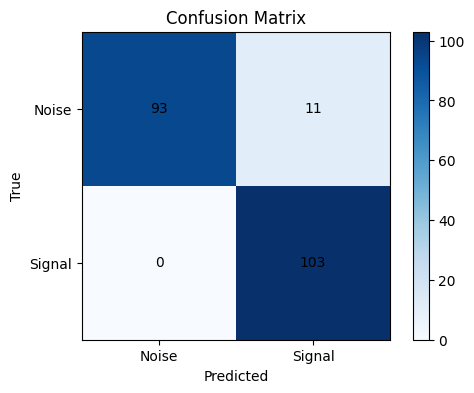

In [54]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Noise', 'Signal'])
plt.yticks([0, 1], ['Noise', 'Signal'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.savefig('confusion_matrix.png')

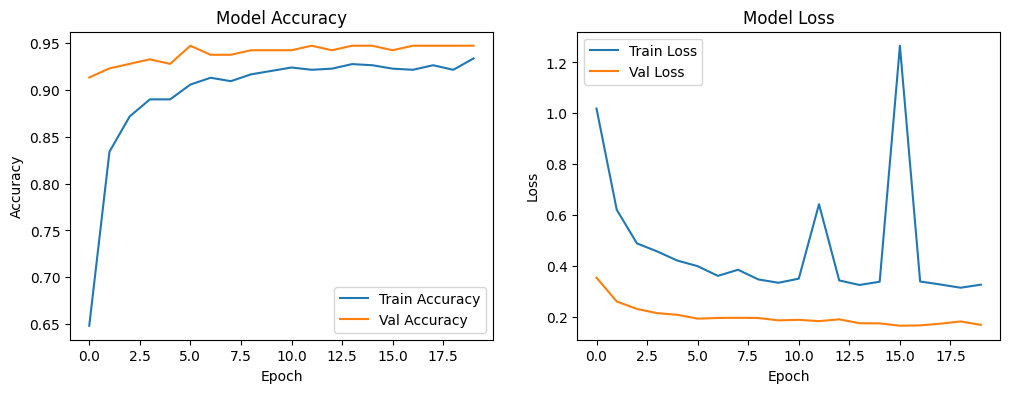

In [55]:
# Training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_history.png')
plt.show()